In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline

C:\Users\BZSJ8M\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def resample_ohlc(df, freq='D'):
    rs = pd.DataFrame()
    rs['open'] = df['open'].resample(freq).first()
    rs['high'] = df['high'].resample(freq).max()
    rs['low'] = df['low'].resample(freq).min()
    rs['close'] = df['close'].resample(freq).last()
    rs['volume'] = df['volume'].resample(freq).sum()
    return rs

def adj_yahoo_prices(df):
    new_df = pd.DataFrame()
    ratio = df['Adj Close'] / df['Close']
    new_df['open'] = df['Open'] * ratio
    new_df['high'] = df['High'] * ratio
    new_df['low'] = df['Low'] * ratio
    new_df['close'] = df['Adj Close']
    new_df['volume'] = df['Volume']
    return new_df

def get_symbol(symbol):
    filename = symbol + '.csv'
    df = pd.read_csv(filename, parse_dates=True, index_col=0)
    df = adj_yahoo_prices(df)
    return df    

def rolling_zscore(series, window):
    rolling_mean = series.rolling(window).mean()
    rolling_std = series.rolling(window).std()
    z_score = (series - rolling_mean) / rolling_std
    return z_score

def true_range(df):
    tr_df = pd.DataFrame()
    tr_df['1'] = np.abs(df['high'] - df['low'])
    tr_df['2'] = np.abs(df['high'] - df['close'].shift(1))
    tr_df['3'] = np.abs(df['low'] - df['close'].shift(1))
    tr = tr_df.max(axis=1)
    return tr

def direction(df):
    return np.sign(df['close'] - df['open'])

def change(df):
    return np.sign(df['close'].pct_change())

def returns(df):
    return df['open'].pct_change().shift(-2)

def bar_range(df):
    _range = df['high'] - df['low']
    return _range

def body_range(df):
    return (np.abs(df['close'] - df['open']))

def up_down(series):
    s = series.copy()
    s[s>0] = 'up'
    s[s<=0] = 'down'
    return s

def sharpe(x):
    return np.mean(x) / np.std(x)

def summary_stats(returns):
    stats = pd.Series()
    gains = returns[returns > 0]
    losses = returns[returns <= 0]
    num_total = len(returns)
    num_gains = len(gains)
    num_losses = len(losses)
    avg = np.mean(returns)
    volatility = np.std(returns)
    sharpe = avg / volatility
    win_pct = num_gains / num_total
    avg_win = np.mean(gains)
    avg_loss = np.mean(losses)
    stats['total returns'] = num_total
    stats['total gains'] = num_gains
    stats['total losses'] = num_losses
    stats['expectancy (%)'] = avg * 100
    stats['volatilty (%)'] = volatility * 100
    stats['sharpe (daily)'] = sharpe
    stats['win %'] = win_pct * 100
    stats['total returns'] = num_total    
    stats['average gain (%)'] = avg_win * 100    
    stats['average loss (%)'] = avg_loss * 100
    return stats

In [3]:
gdx = get_symbol('GDX')
gdx['true_range'] = true_range(gdx)
gdx['direction'] = direction(gdx)
gdx['change'] = change(gdx)
gdx['returns'] = returns(gdx)
window = 20
gdx['v_norm'] = rolling_zscore(gdx['volume'], window)
gdx['tr_norm'] = rolling_zscore(gdx['true_range'], window)
gdx.dropna(inplace=True)

C:\Users\BZSJ8M\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in sign


0.747888574839


Text(0.5,1,'GDX Volume vs Volatility')

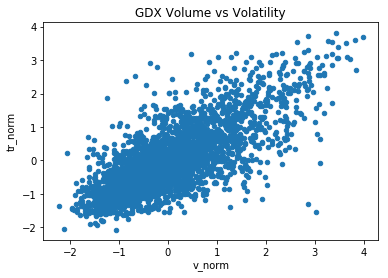

In [4]:
vol_correlation = gdx['v_norm'].corr(gdx['tr_norm'])
print(vol_correlation)
gdx.plot(kind='scatter', x='v_norm', y='tr_norm')
plt.title('GDX Volume vs Volatility')

In [5]:
import statsmodels.api as sm
gdx.dropna(inplace=True)
X = gdx['v_norm']
X = sm.add_constant(X)
y = gdx['tr_norm']
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                tr_norm   R-squared:                       0.559
Model:                            OLS   Adj. R-squared:                  0.559
Method:                 Least Squares   F-statistic:                     3734.
Date:                Tue, 13 Mar 2018   Prob (F-statistic):               0.00
Time:                        14:14:37   Log-Likelihood:                -2951.5
No. Observations:                2944   AIC:                             5907.
Df Residuals:                    2942   BIC:                             5919.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0342      0.012     -2.812      0.005      -0.058      -0.010
v_norm         0.7194      0.012     61.109      0.000       0.696       0.743
==============================================================================
Omnibus:                      180.828   Durbin-Watson:                   1.864
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              440.999
Skew:                           0.362   Prob(JB):                     1.73e-96
Kurtosis:                       4.752   Cond. No.                         1.04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

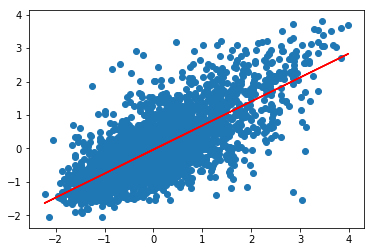

In [6]:
y_pred = model.predict(X)
plt.scatter(X.iloc[:,1], y)
plt.plot(X.iloc[:,1], y_pred, color='r')

Text(0.5,1,'Probability Plot of Model Residuals')

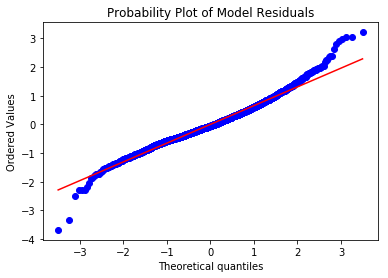

In [7]:
from scipy import stats
from matplotlib import pylab
resid = y - y_pred
gdx['resid'] = resid
stats.probplot(gdx['resid'], plot=pylab)
plt.title('Probability Plot of Model Residuals')

Text(0.5,1,'Up Day Returns, Grouped by Model Residual Percentile')

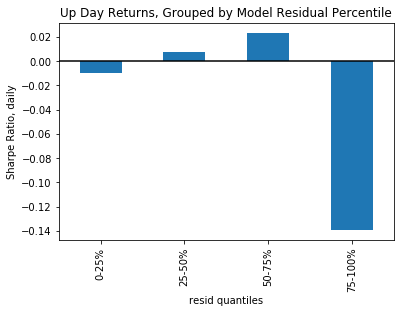

In [33]:
gdx['resid quantiles'] = pd.qcut(gdx['resid'], 4)
up_days = gdx[gdx['direction'] > 0]
down_days = gdx[gdx['direction'] <= 0]
up_days['returns'].groupby(up_days['resid quantiles']).apply(sharpe).plot(kind='bar')
plt.axhline(0, color='k')
plt.xticks(np.arange(4), ('0-25%', '25-50%', '50-75%', '75-100%'))
plt.ylabel('Sharpe Ratio, daily')
plt.title('Up Day Returns, Grouped by Model Residual Percentile')

Text(0.5,1,'Down Day Returns, Grouped by Model Residual Percentile')

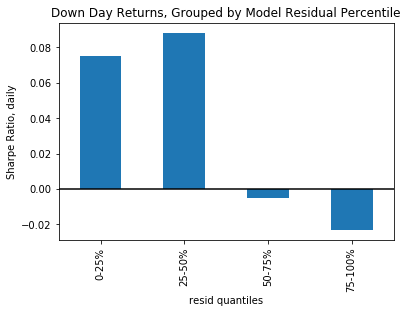

In [34]:
down_days['returns'].groupby(down_days['resid quantiles']).apply(sharpe).plot(kind='bar')
plt.axhline(0, color='k')
plt.xticks(np.arange(4), ('0-25%', '25-50%', '50-75%', '75-100%'))
plt.ylabel('Sharpe Ratio, daily')
plt.title('Down Day Returns, Grouped by Model Residual Percentile')

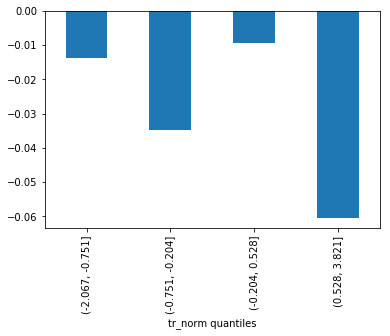

In [21]:
gdx['tr_norm quantiles'] = pd.qcut(gdx['tr_norm'], 4)
up_days = gdx[gdx['direction'] > 0]
down_days = gdx[gdx['direction'] <= 0]
up_days['returns'].groupby(up_days['tr_norm quantiles']).apply(sharpe).plot(kind='bar')

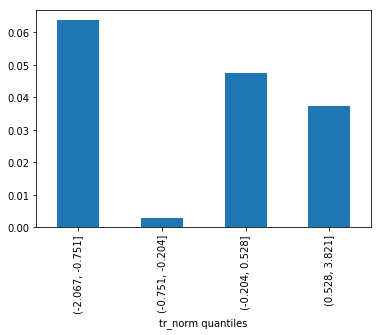

In [22]:
down_days['returns'].groupby(down_days['tr_norm quantiles']).apply(sharpe).plot(kind='bar')

Text(0.5,14.0938,'Volume-Volatility Correlation')

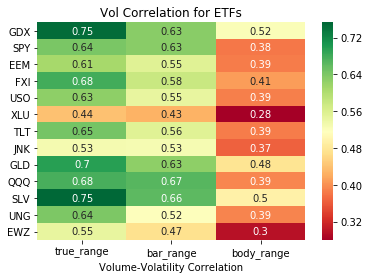

In [40]:
symbols = ['GDX', 'SPY', 'EEM', 'FXI', 'USO', 'XLU', "TLT", 'JNK', 'GLD', 'QQQ', 'SLV', 'UNG', 'EWZ']
data_dict = {}
window = 20
correlations = pd.DataFrame()
for symbol in symbols:
    df = get_symbol(symbol)
    df['true_range'] = true_range(df)
    df['true_range2'] = df['true_range'].rolling(2).mean()
    df['volume2'] = df['volume'].rolling(2).mean()
    df['range'] = bar_range(df)
    df['body_range'] = body_range(df)
    df['direction'] = direction(df)
    df['returns'] = returns(df)
    df['r_score'] = rolling_zscore(df['true_range'], window)
    df['r_score2'] = rolling_zscore(df['range'], window)
    df['r_score3'] = rolling_zscore(df['body_range'], window)
    df['r2_score'] = rolling_zscore(df['true_range2'], window)
    df['v_score'] = rolling_zscore(df['volume'], window)
    df['v2_score'] = rolling_zscore(df['volume2'], window)
    data_dict[symbol] = df
    correlations.loc[symbol, 'true_range'] = df['v_score'].corr(df['r_score'])
    correlations.loc[symbol, 'bar_range'] = df['v_score'].corr(df['r_score2'])
    correlations.loc[symbol, 'body_range'] = df['v_score'].corr(df['r_score3'])
    #correlations.loc[symbol, 'true_range2'] = df['v2_score'].corr(df['r2_score'])
sns.heatmap(correlations, cmap='RdYlGn', annot=True)
plt.title('Vol Correlation for ETFs')
plt.xlabel('Volume-Volatility Correlation')

([<matplotlib.axis.XTick at 0x1909df209e8>,
 <a list of 4 Text xticklabel objects>)

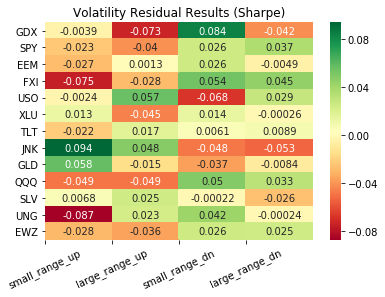

In [71]:
results = pd.DataFrame()
for symbol in symbols:
    df = data_dict[symbol].copy()
    df.dropna(inplace=True)
    X = df['v_score'].values
    X = sm.add_constant(X)
    y = df['r_score'].values
    model = sm.OLS(y,X).fit()
    pred = model.predict(X)
    # Positive -> Bigger range than expected
    # Negative -> Smaller range than expected
    df['resid'] = y - pred
    small_range_up = (df['resid']<0) & (df['direction']>0)
    small_range_dn = (df['resid']<0) & (df['direction']<0)
    large_range_up = (df['resid']>0) & (df['direction']>0)
    large_range_dn = (df['resid']>0) & (df['direction']<0) 
    df['returns'] = df['returns'] - df['returns'].mean()
    # results.loc[symbol, 'benchmark'] = sharpe(df['returns'])
    results.loc[symbol, 'small_range_up'] = sharpe(df.loc[small_range_up, 'returns'])    
    results.loc[symbol, 'large_range_up'] = sharpe(df.loc[large_range_up, 'returns'])
    results.loc[symbol, 'small_range_dn'] = sharpe(df.loc[small_range_dn, 'returns'])
    results.loc[symbol, 'large_range_dn'] = sharpe(df.loc[large_range_dn, 'returns'])
#results = results.sub(results['benchmark'], axis=0)
sns.heatmap(results, cmap='RdYlGn', annot=True)
plt.title('Volatility Residual Results (Sharpe)')
plt.xticks(np.arange(4), results.columns, rotation=25)

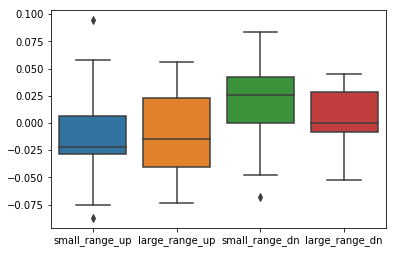

In [72]:
sns.boxplot(data=results)

In [73]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
stacked = pd.DataFrame(results.stack())
stacked.reset_index(level=1, inplace=True)
stacked.columns = ['class_', 'sharpe']
#stacked.head()
mod = ols('sharpe ~ C(class_)', data=stacked).fit()
anova_table = sm.stats.anova_lm(mod, typ=2)
print(anova_table)

             sum_sq    df         F    PR(>F)
C(class_)  0.005101   3.0  0.992038  0.404574
Residual   0.082274  48.0       NaN       NaN


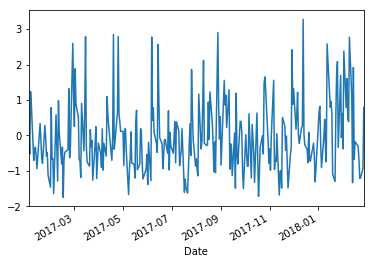

In [74]:
gdx.loc['2017':, 'v_norm'].plot()

In [75]:
up_spikes = (gdx['v_norm'] > 2) & (gdx['direction'] > 0)
down_spikes = (gdx['v_norm'] > 2) & (gdx['direction'] <= 0)
stats = pd.DataFrame()
stats['GDX'] = summary_stats(gdx['returns'])
stats['up spikes'] = summary_stats(gdx.loc[up_spikes, 'returns'])
stats['down spikes'] = summary_stats(gdx.loc[down_spikes, 'returns'])
stats

,GDX,up spikes,down spikes
total returns,2944.000000,67.000000,87.000000
total gains,1439.000000,24.000000,39.000000
total losses,1505.000000,43.000000,48.000000
expectancy (%),0.022364,-0.224842,-0.288105
volatilty (%),2.683811,2.617039,2.919071
sharpe (daily),0.008333,-0.085915,-0.098698
win %,48.879076,35.820896,44.827586
average gain (%),2.007449,2.251660,2.087370
average loss (%),-1.875666,-1.607076,-2.218179


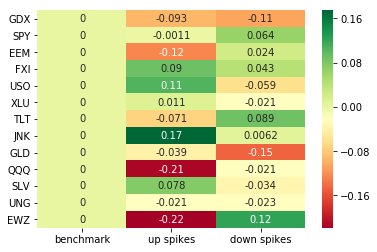

In [76]:
spike_results = pd.DataFrame()
for symbol in symbols:
    data = data_dict[symbol]
    up_spikes = (data['v_score'] > 2) & (data['direction'] > 0)
    down_spikes = (data['v_score'] > 2) & (data['direction'] <= 0)
    spike_results.loc[symbol, 'benchmark'] = sharpe(data['returns'])
    spike_results.loc[symbol, 'up spikes'] = sharpe(data.loc[up_spikes, 'returns'])
    spike_results.loc[symbol, 'down spikes'] = sharpe(data.loc[down_spikes, 'returns'])
spike_results = spike_results.sub(spike_results['benchmark'], axis=0)
sns.heatmap(spike_results, cmap='RdYlGn', annot=True)

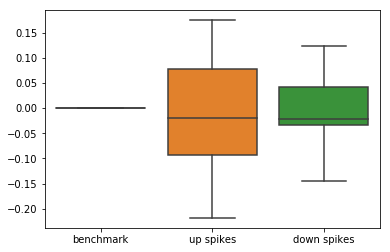

In [77]:
sns.boxplot(data=spike_results)

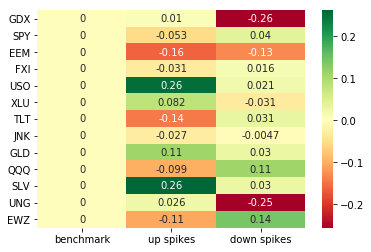

In [78]:
range_spikes = pd.DataFrame()
for symbol in symbols:
    data = data_dict[symbol]
    up_spikes = (data['r_score'] > 2) & (data['direction'] > 0)
    down_spikes = (data['r_score'] > 2) & (data['direction'] <= 0)
    range_spikes.loc[symbol, 'benchmark'] = sharpe(data['returns'])
    range_spikes.loc[symbol, 'up spikes'] = sharpe(data.loc[up_spikes, 'returns'])
    range_spikes.loc[symbol, 'down spikes'] = sharpe(data.loc[down_spikes, 'returns'])
range_spikes = range_spikes.sub(range_spikes['benchmark'], axis=0)
sns.heatmap(range_spikes, cmap='RdYlGn', annot=True)

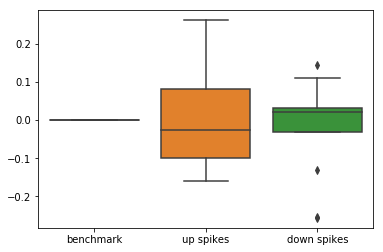

In [79]:
sns.boxplot(data=range_spikes)